In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [8]:
#Hydrogen world summer project script
#Computes semigrey OLR for H2 atmosphere on dry adiabat
#Assumes optically thin stratosphere


from ClimateUtilities import *
import phys
import math
import matplotlib as mpl
from ipywidgets import *
import miniClimtFancyCIABand as rad
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time

import seaborn
seaborn.set_style("whitegrid")
seaborn.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
seaborn.set_color_codes()

%matplotlib inline


#Import radiation module
import miniClimtFancyCIABand as rad
#Import rad-conv stepper (with Cp(T) and adiabatic adjustment)
import HWRadConv as RC
#Import general modules
import math,phys
import planets
from ClimateUtilities import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#Import optional seaborn plotting library
import seaborn
seaborn.set_style("whitegrid")
seaborn.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
seaborn.set_color_codes()

#Needed while editing these modules
reload(rad)
reload(RC)




def RadConv(L,Tg,mode):
    #--------------Initializations-------------------------------------------

    #Set initial time step
    dtime = 1.e-4 # 1. # (for CO2 case; gray gas evolves faster)

    #Set number of levels in pressure array
    n = 10

    #Set global constants
    ps = 1.e5 * 10
    rh = 1.e-30#Relative humidity
    rhbdd = 1.e-30
    dt = 24.*3600. * dtime#time step in seconds

    Tg=Tg
    #---Set up pressure array (a global)----
    ptop = 50. #Top pressure in mb (Changed from 1mb in original)
    pstart = .995*ps
    rat = (ptop/pstart)**(1./n)
    logLevels = [pstart*rat**i for i in range(n)]
    logLevels.reverse()
    levels = [ptop + i*(pstart-ptop)/(n-1) for i in range(n)]
    #p=Numeric.array(levels,Numeric.Float)
    p = numpy.array(logLevels)

    #--------------Other parameters-------------------------------------------
    #Set the gravity and thermodynamic constants
    Rcp = 2./7.
    
    if mode == "Adiabat":
        T = Tg*(p/p[-1])**Rcp
    else:
        T = Tg*numpy.ones(len(p))
    
    rad.tauInf = 5.
    RC.q=numpy.ones(len(p))

    #-------Set constants-----------
    rad.g = 28. #Set gravity
    rad.LWCutoff = 1.e6 #Thermal longwave cutoff; speeds up calc
    rad.Tstellar = 5373.#
    rad.Lstellar = L
    rad.bandData = rad.loadContinuumBands('H2_CIA_HOT.dat')
    rad.pref = 1.e5
    rad.Tref = 2800

    #--------------Model options-------------------------------------------
    #Toggle shortwave absorption
    RC.doStellarAbs = True
    #Toggle variable heat capacity Cp(T)
    RC.doVarRcp = True
    #Toggle surface T balance equation
    RC.doTgBalance = True


    #--------------Plotting setup-------------------------------------------
    #Set up kappa, wavenumber, and black body lists
    kappaList = []
    nuList = []
    bbList = []
    for i in range(len(rad.bandData)):
        nuList.append(rad.bandData[i].nu1)
        kappaList.append(rad.bandData[i].kappa)

    #Brightness T function
    def calcBrightT(I,nu):
        f = nu * 100 * phys.c
        return 1 / ((phys.k / (phys.h * f)) * numpy.log((2 * phys.h * f ** 3 * 100 * math.pi)/(phys.c * I) + 1))


    #---------------------------------------------------------
    #--------------Initializations Done-----------------------
    #--------------Now do the time stepping-------------------
    #---------------------------------------------------------
    for i in range(0,50):
        
        dt = dt * 0.99
        #plt.close()
        #oldT=numpy.array(T)
        #if i%50 == 0 & i > 200:
        #     dtime = .5*dtime
        oldT=T[:]
        oldTg=Tg
        Tg,Tad,T,flux,fluxStellar,fluxLW,heat,heatStellar,heatLW,fluxBandList = RC.steps(Tg,T,p,1,dt)
        fig = plt.figure(figsize=(16,5))
        gs1 = gridspec.GridSpec(1,2)
        ax_list = [fig.add_subplot(ss) for ss in gs1]



        #Plot local adiabats for comparison
        #for j in range(400,8000,800):
        #    Tad = j*(p/p[-1])**Rcp
        #    ax_list[0].plot(Tad,p/1e5,'0.8')
        #    ax_list[1].semilogy(Tad,p/1e5,'0.8')

        ax_list[0].plot(T,p/1e5,'k')
        #line.set_ydata(T)
        ax_list[0].invert_yaxis()
        ax_list[0].set_xlim([0,4000])
        #ax_list[0].set_ylim([0.1,1000])
        ax_list[0].set_xlabel('Temperature (K)')
        ax_list[0].set_ylabel('Pressure (bar)')
        ax_list[0].set_title('Temperature Profile', fontsize=20, y=1.04)

        #ax_list[0].text(100,270000, 'Ground =  {Tg} K'.format(Tg=int(Tg)))

        ax_list[1].semilogy(T,p/1e5,'k')
        ax_list[1].set_xlim([0,4000])
        ax_list[1].set_ylim([0.001,ps/1e5])
        ax_list[1].invert_yaxis()    
        ax_list[1].set_xlabel('Temperature (K)')
        ax_list[1].set_ylabel('Pressure (bar)')
        ax_list[1].set_title('Semilog Temperature Profile', fontsize=20, y=1.04)
        #plt.show()

        bbList = []
        #for j in range(len(rad.bandData)):
        #    bbList.append(rad.Planck(rad.bandData[j].nu1, Tg))

        

        #ax_list[2].semilogy(T-oldT,p/1e5,'k')
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)

        #print i,Tg,T[-1]
    





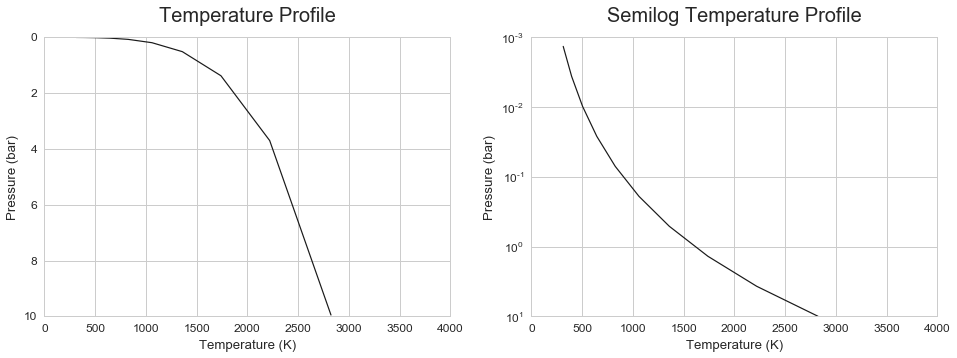

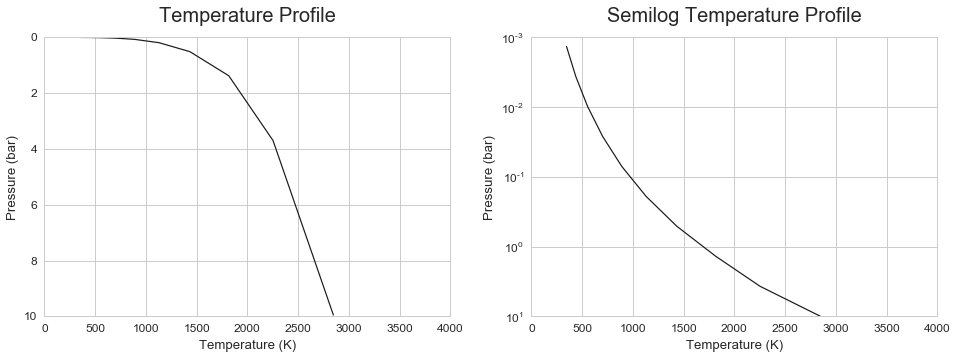

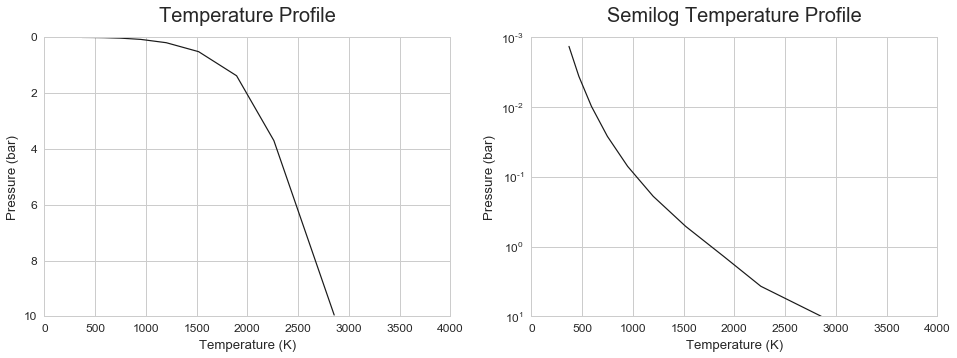

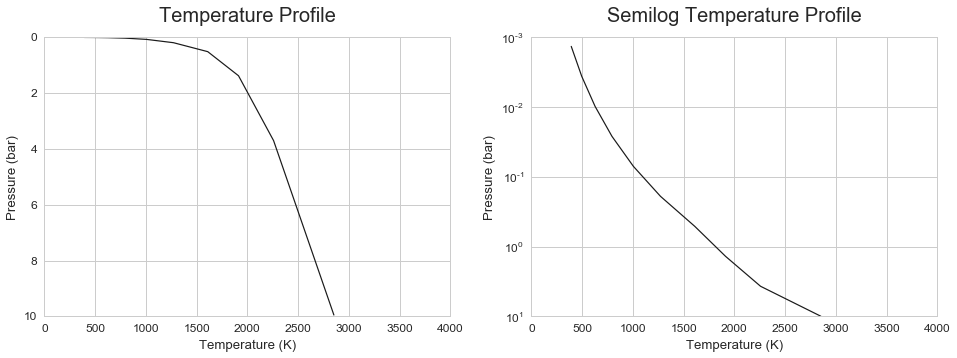

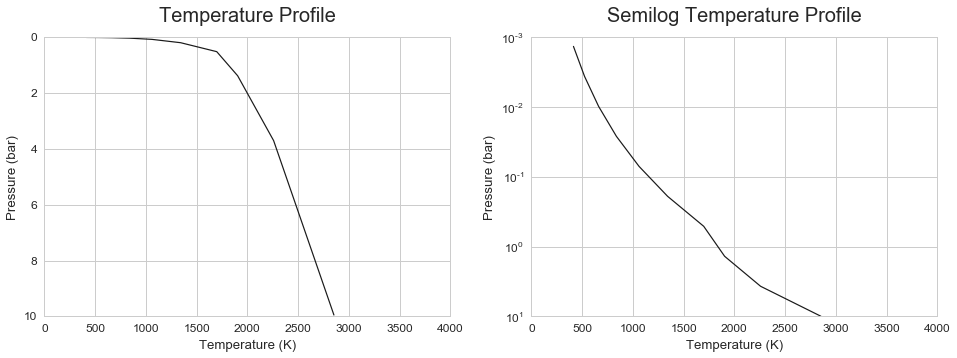

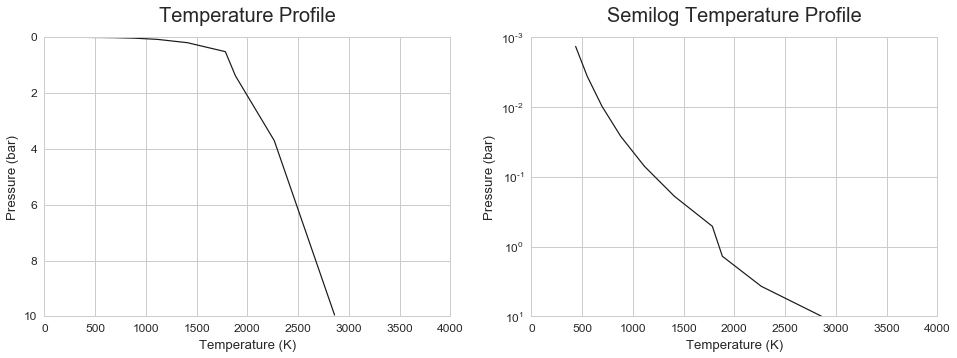

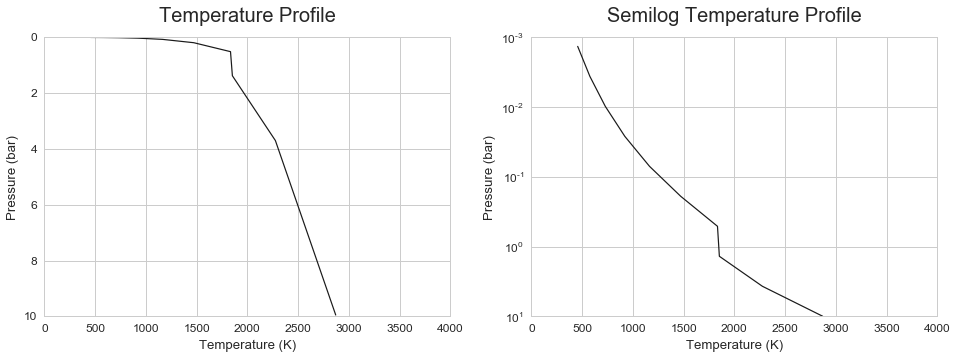

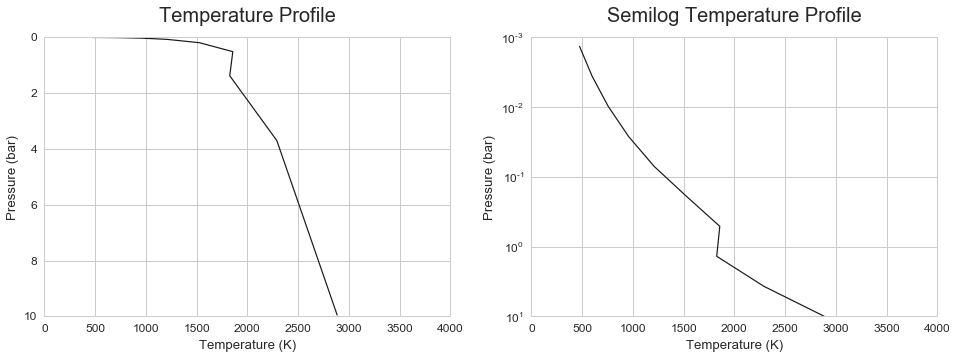

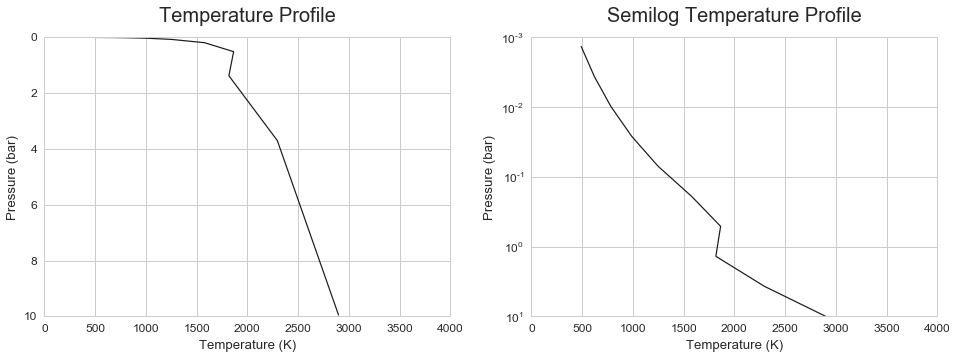

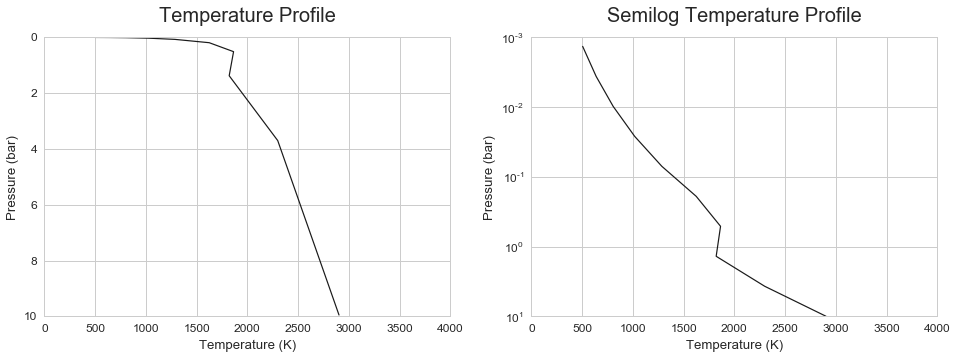

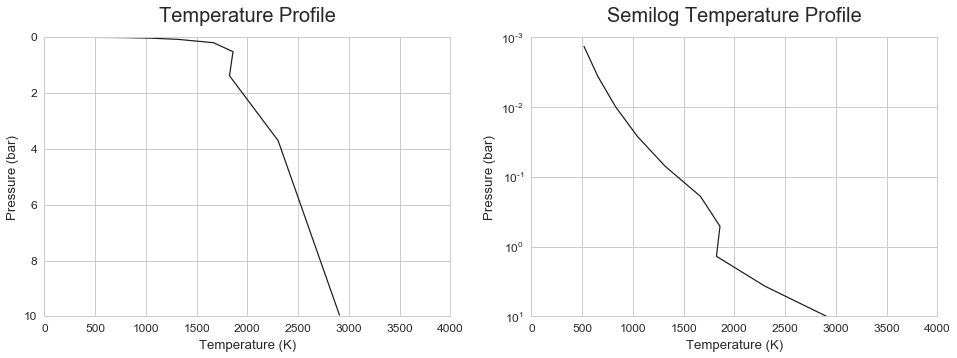

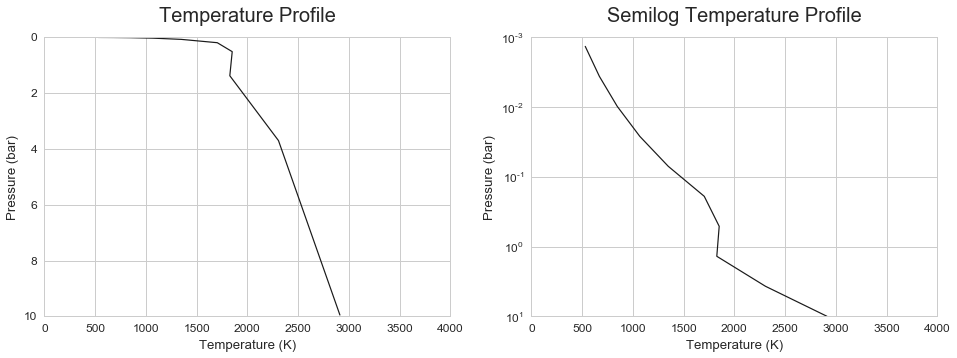

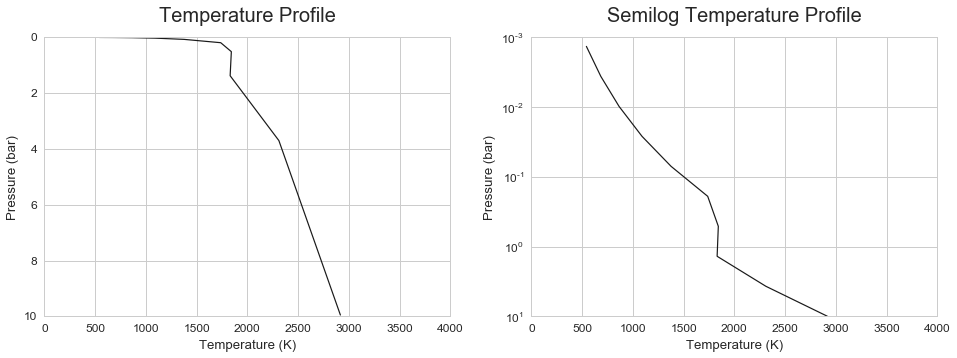

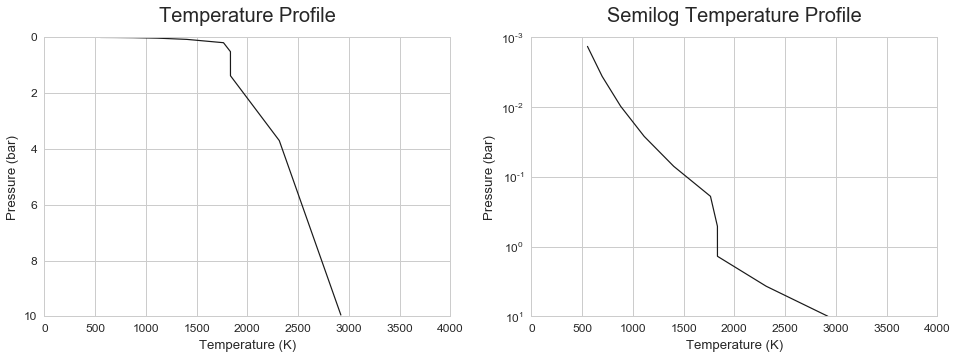

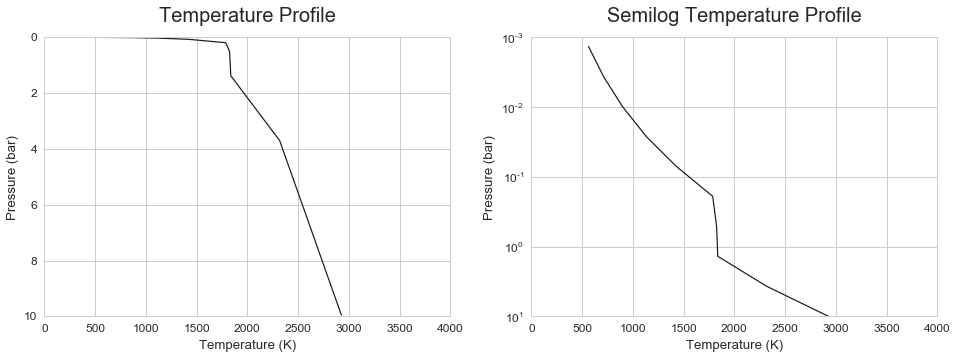

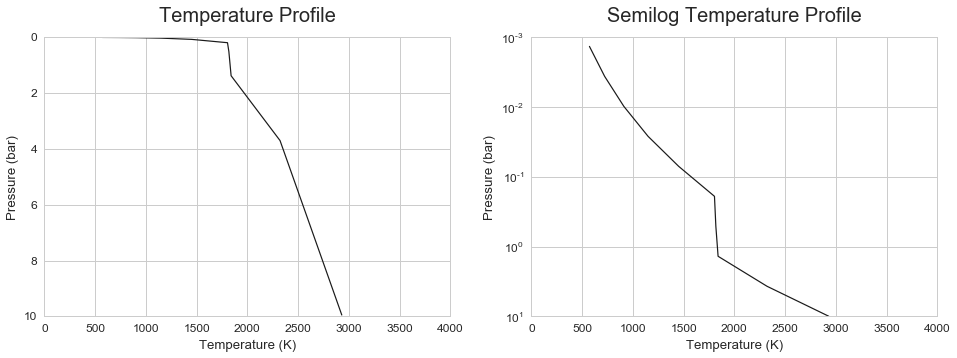

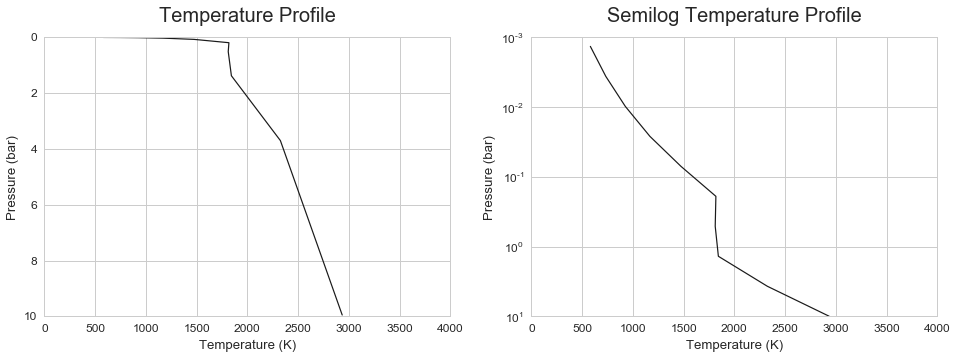

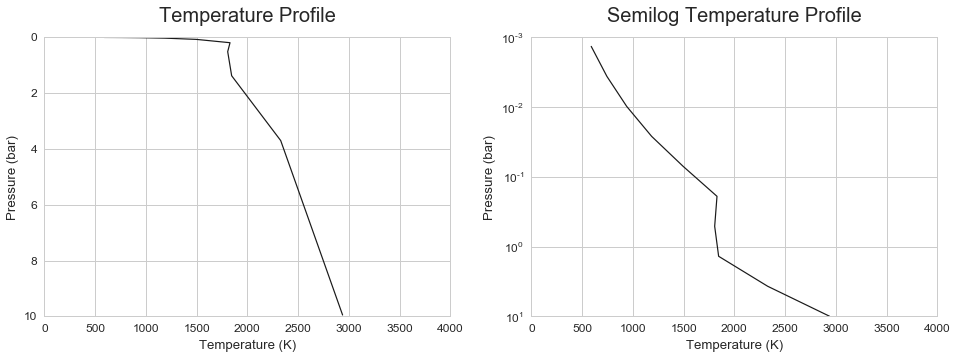

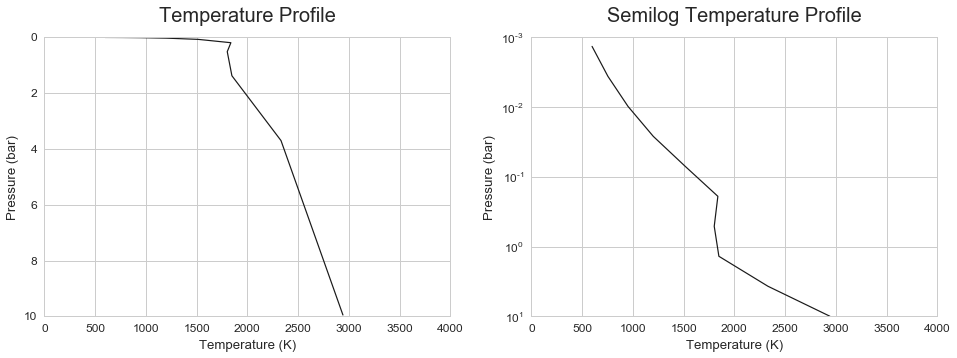

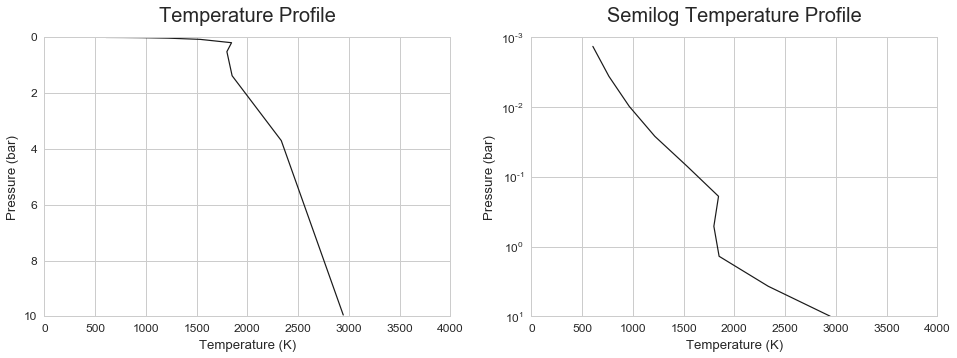

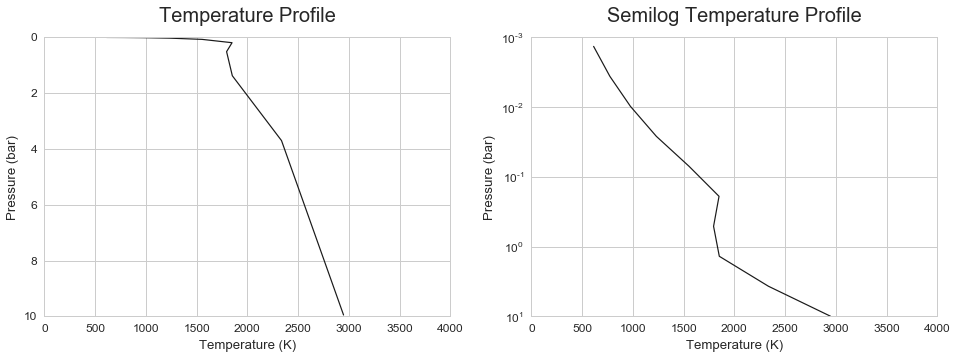

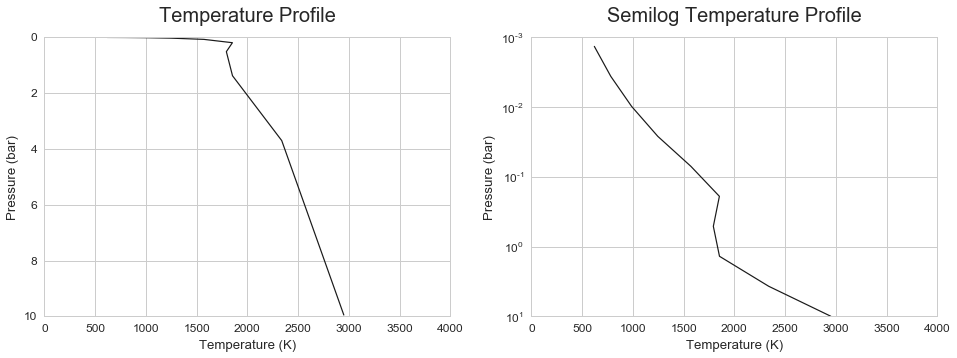

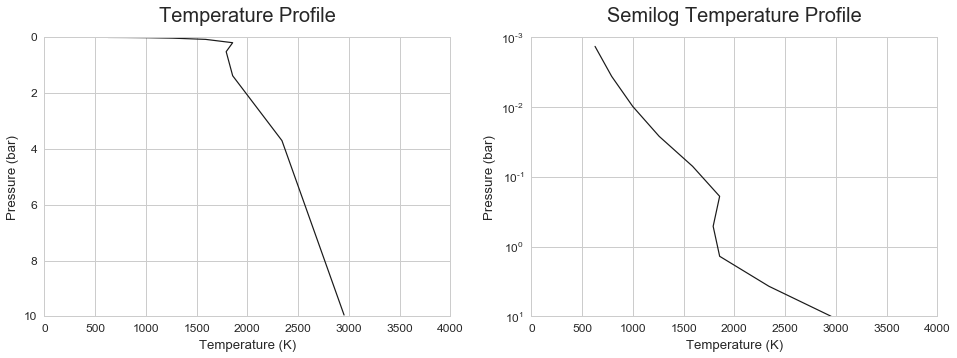

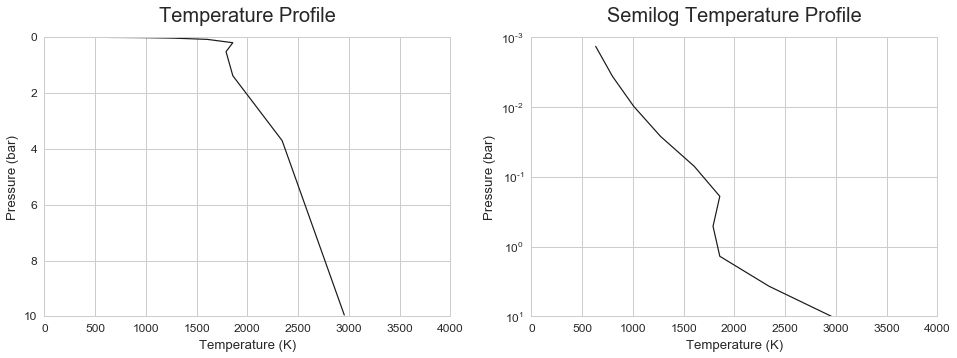

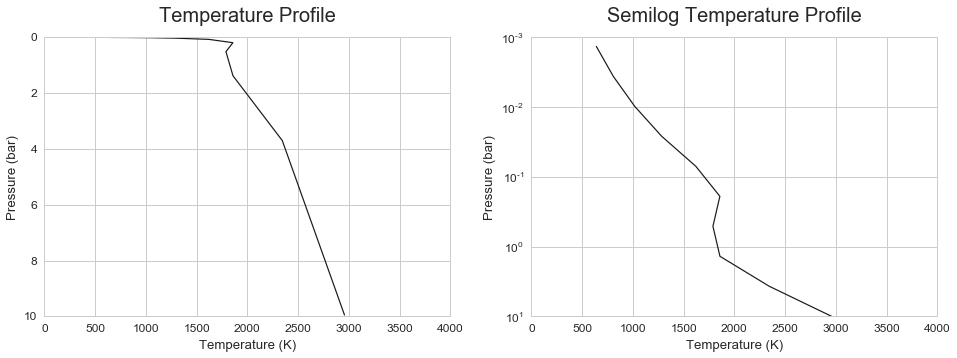

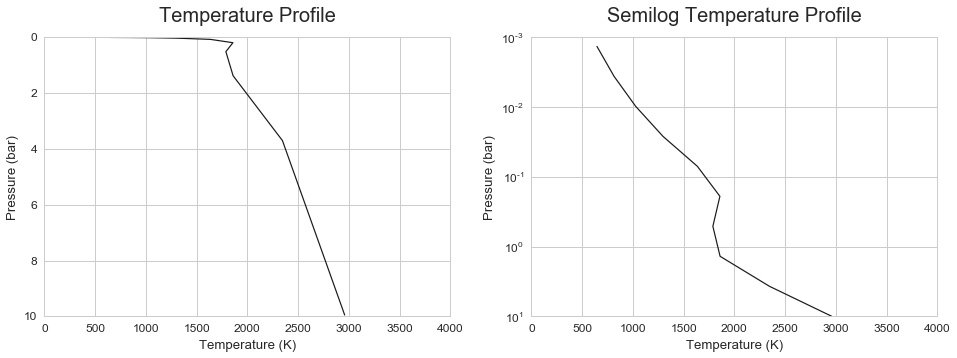

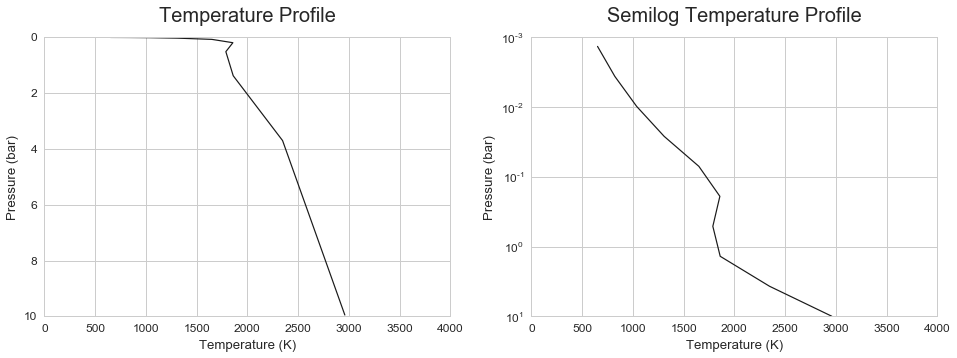

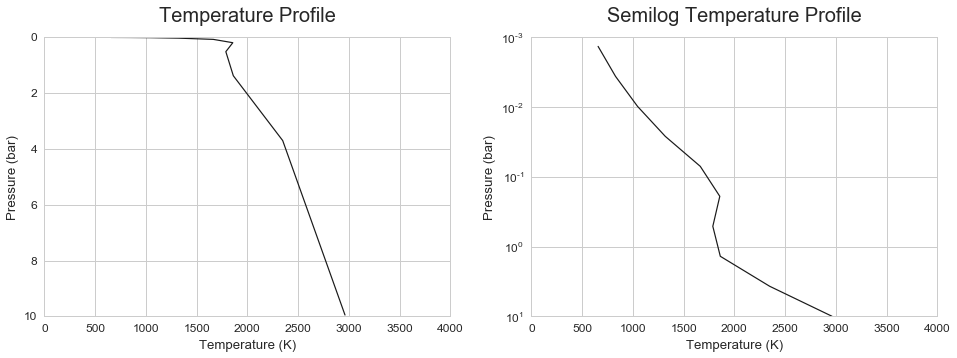

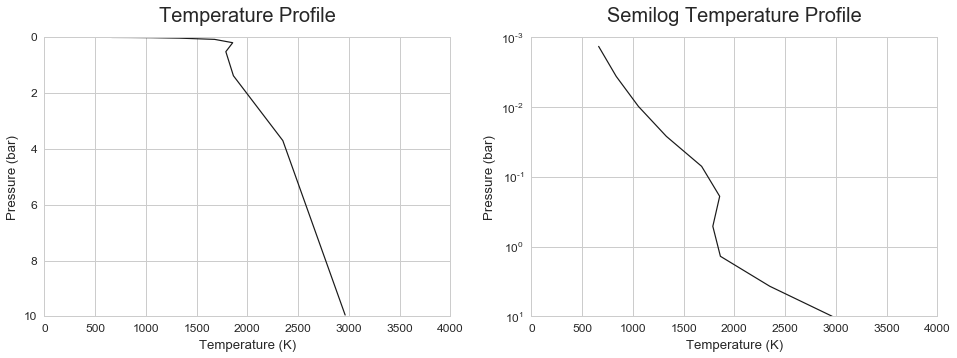

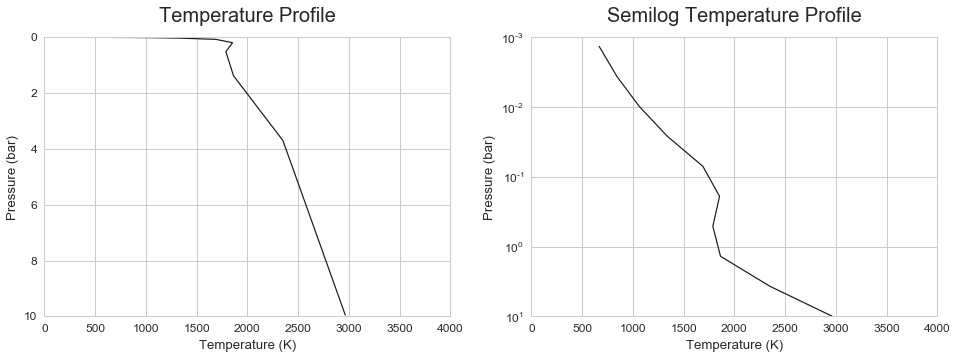

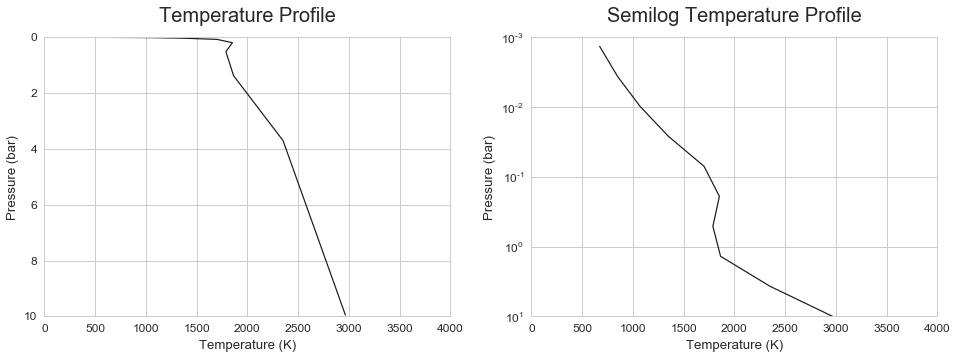

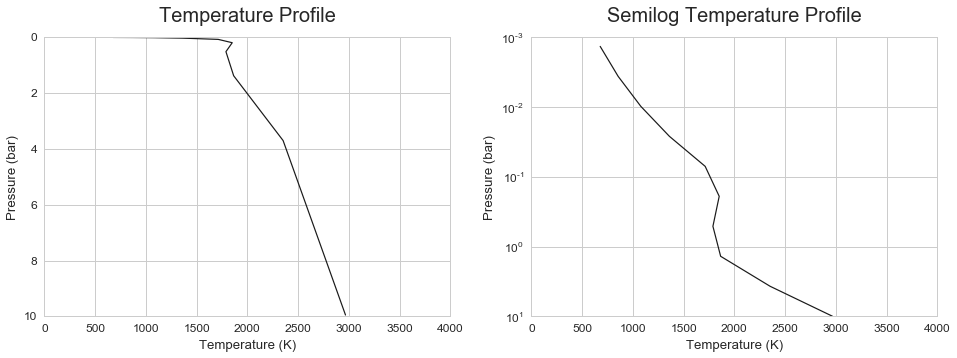

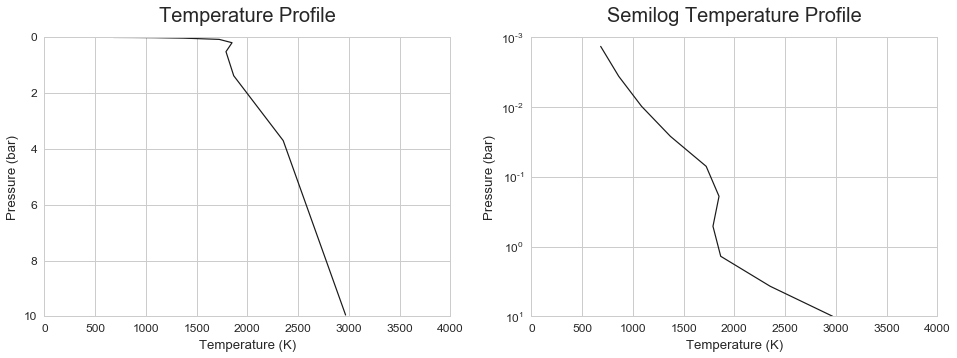

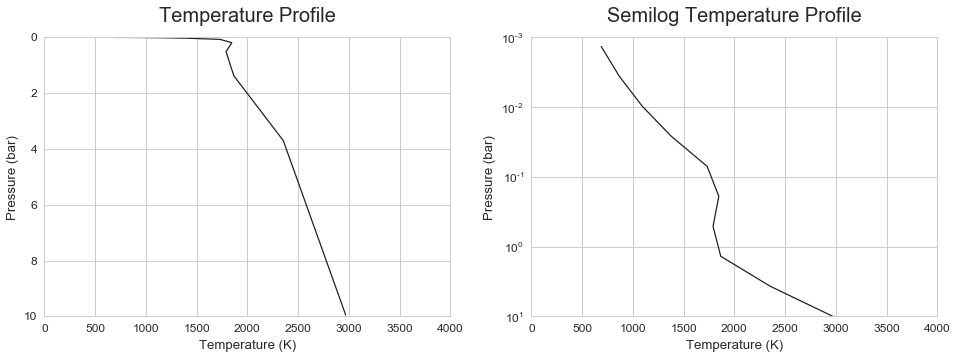

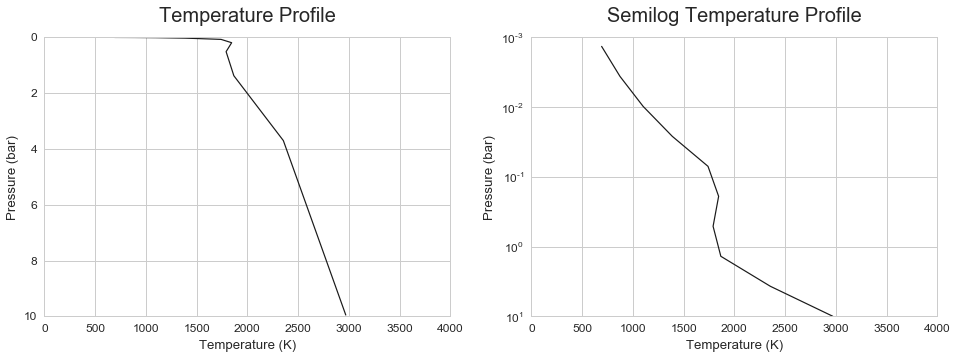

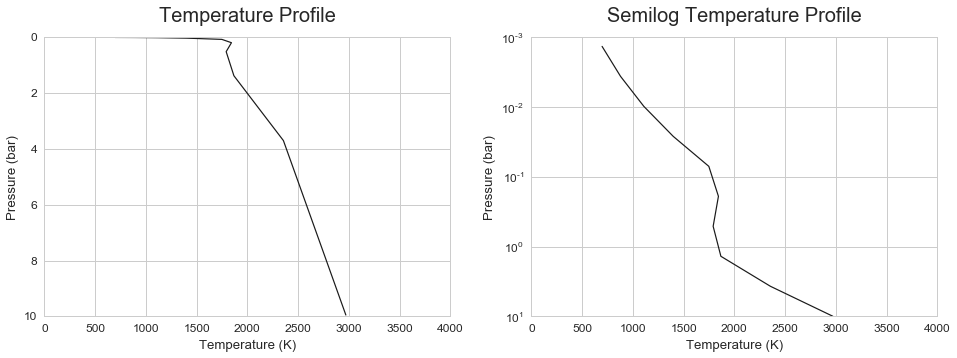

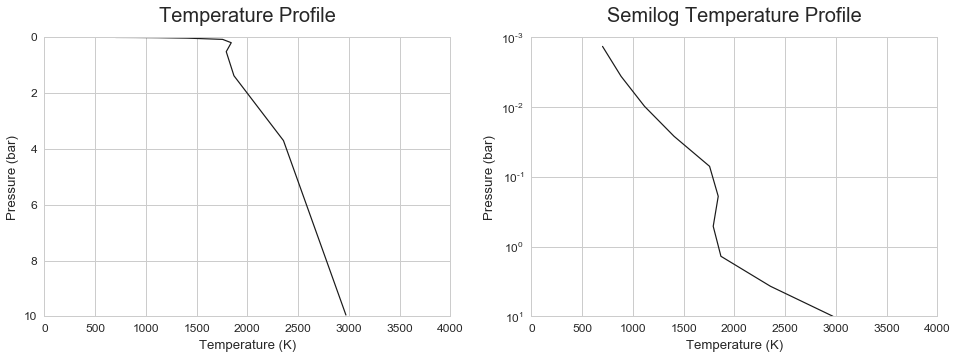

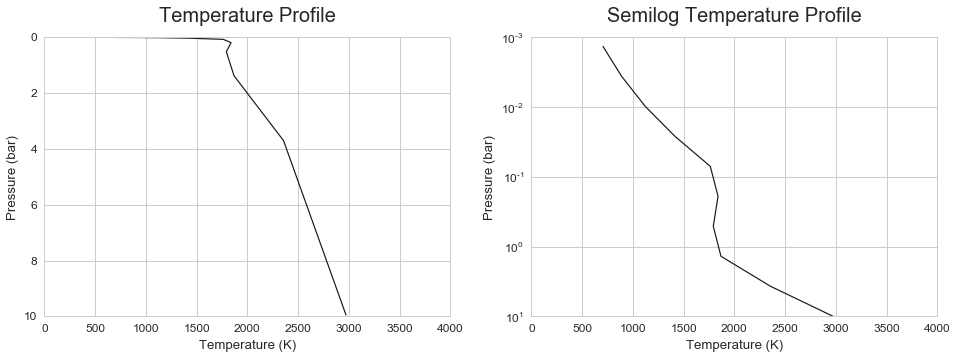

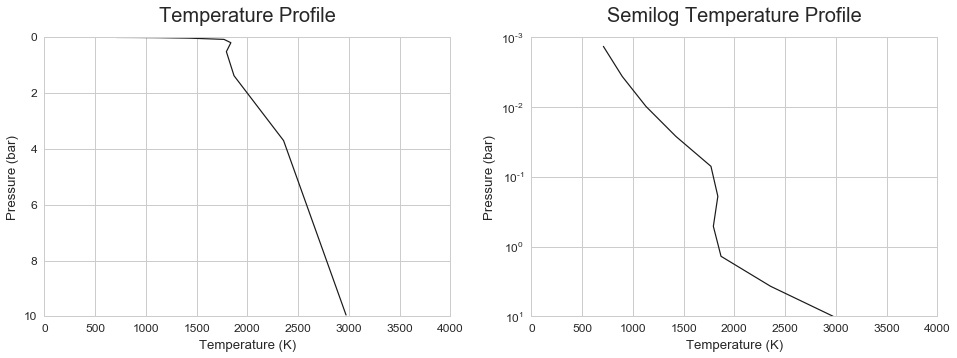

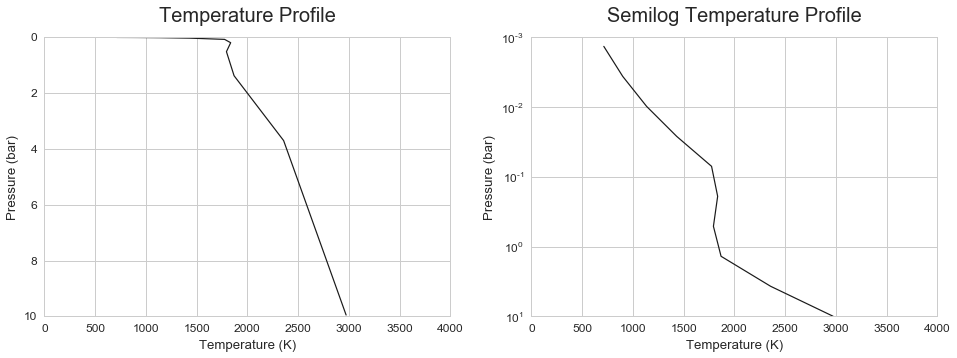

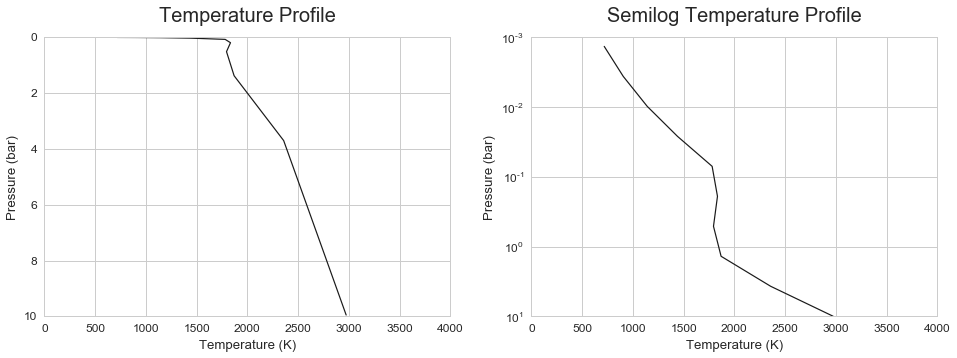

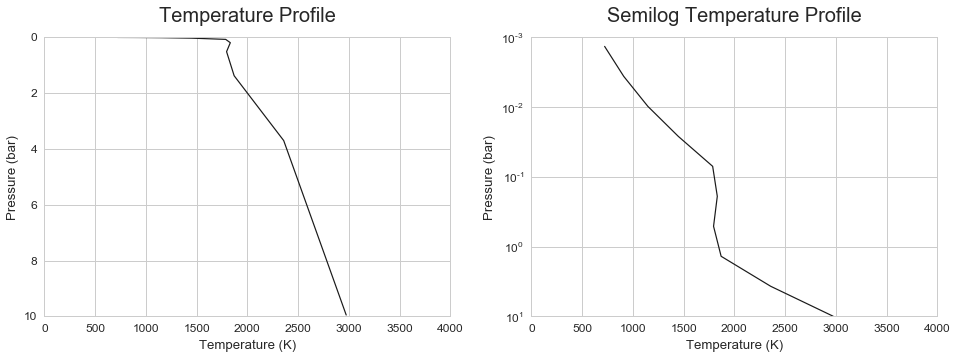

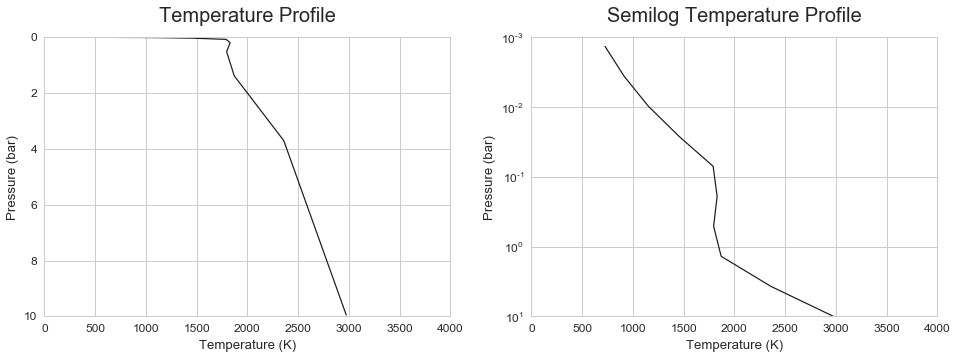

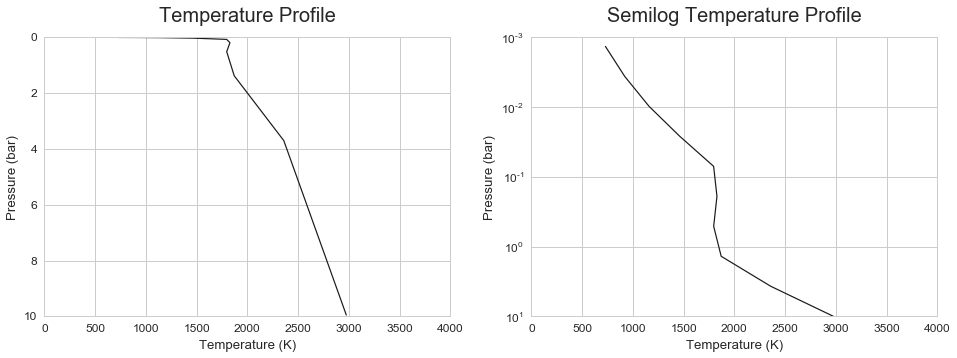

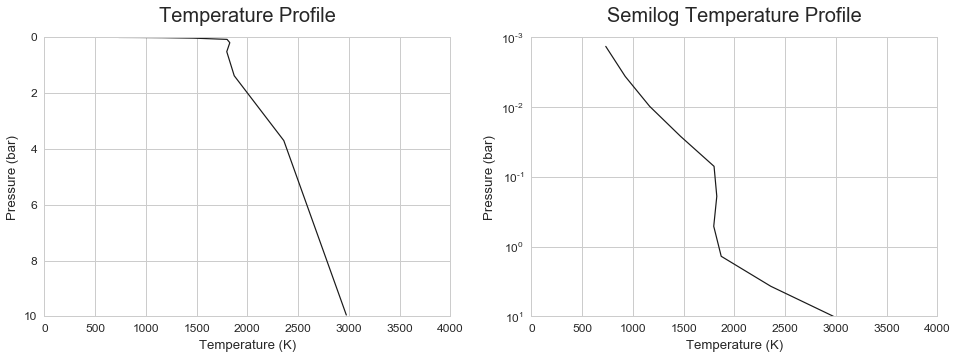

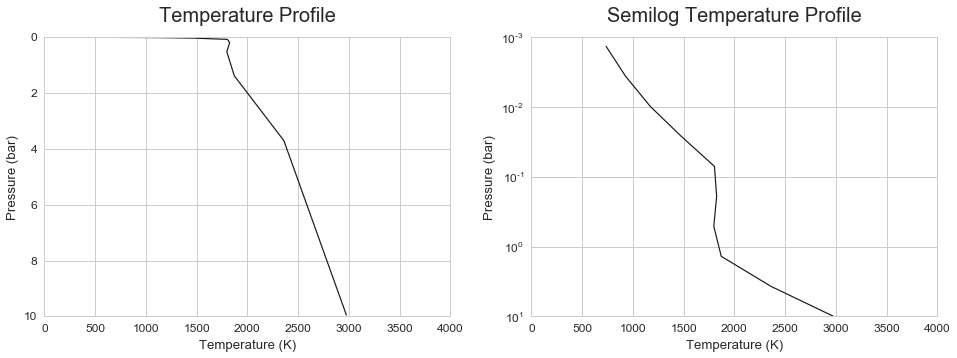

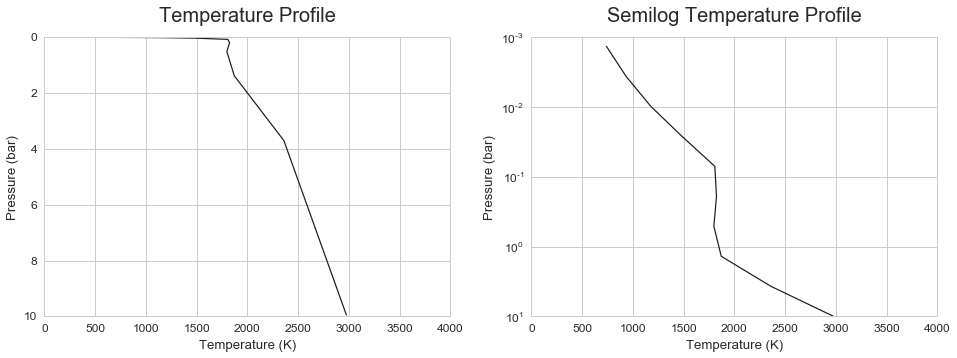

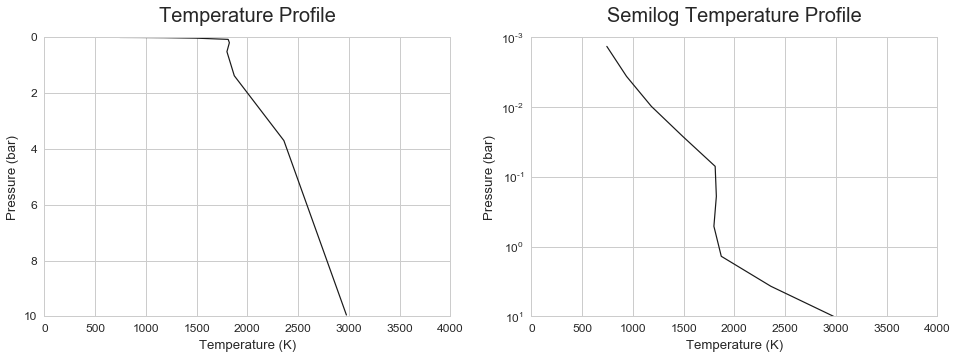

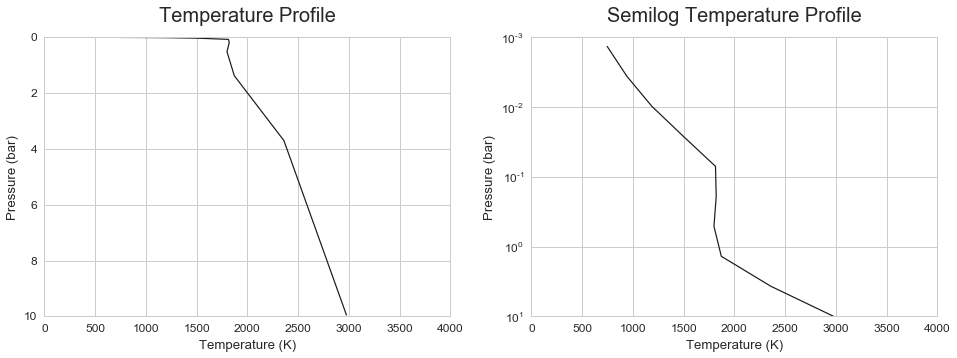

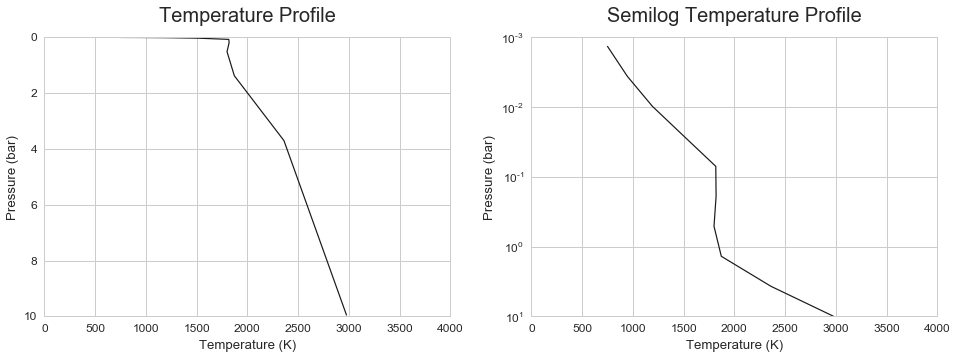

In [9]:
interact(RadConv, L=widgets.IntSlider(min=1350.*2590.,max=1350.*2590.*4.,step=1000,value=1350.*2590.*2.),Tg=widgets.IntSlider(min=2000,max=3000.,step=100,value=2500),mode=('Adiabat','Isotherm'),__manual=True);